#Creating the Spectrogram Images!

By using Librosa, I aim to create three separate spectrograms: 


*   Spectrogram 
*   Mel Spectrogram 
*   MFCC Spectrogram. 



#Download Dataset from Kaggle

In [ ]:
%%bash 
pip uninstall -y kaggle 
pip install --upgrade pip 
pip install kaggle==1.5.6 
kaggle -v 
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
kaggle competitions download -c tensorflow-speech-recognition-challenge
unzip /content/tensorflow-speech-recognition-challenge.zip

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=b7f21a923fed1987524e28998d68268190b2ca3cb07bdcaa37486a0313ad0d0b
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle

Archive:  /content/tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
100%|██████████| 3.50G/3.50G [00:41<00:00, 89.8MB/s]


#Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pyunpack import Archive


#Unzip Data

Let's unzip the `.7z` files using `Archive` from `pyunpack`.

In [ ]:
PATH = '/content/'

Archive('/content/train.7z').extractall(PATH)

#Looking at the Dataset

In [ ]:
train_dir = os.path.join(PATH,'train')
train_audio = os.path.join(train_dir,'audio')

As showcased below there are a total of 30 categories. The category `_background_noise_` was provided to us to help the model recognize silence. 

In [ ]:
def total_values(seg):
  sum, cats = 0, os.listdir(train_audio)
  print(f'Total number of categories is {len(cats)-1}')

  audio, snippet = [], []

  for cat in cats:
    if cat != '_background_noise_':
      pth = os.path.join(train_audio, cat)
      files = [os.path.join(pth, f) for f in os.listdir(pth)]
      audio.append(files)
      snippet.append(files[0])
      numbs = len(files)
      print(cat, numbs)
      sum += numbs

  print(f'Total number of {seg} examples are {sum}')

  return cats, [j for cat in audio for j in cat], snippet
cats, examples, snippet = total_values('training')

Total number of categories is 30
right 2367
up 2375
wow 1745
seven 2377
marvin 1746
go 2372
five 2357
stop 2380
bed 1713
no 2375
bird 1731
yes 2377
left 2353
cat 1733
two 2373
four 2372
zero 2376
off 2357
eight 2352
happy 1742
three 2356
one 2370
sheila 1734
on 2367
down 2359
tree 1733
six 2369
nine 2364
house 1750
dog 1746
Total number of training examples are 64721


`examples` holds  the locations for the audio clips from different categories. Since, the path specifies the categories, we can use a 1D list. <br>

`cats` holds the various categories our model can predict for any random audio clip.


`snippet` contains a small segement of the examples on which we can practice creating the spectograms. 

In [ ]:
len(examples)

64721

#Creating Images from The Audio Files

A sampling rate is inversely propotionate to the amount of time between successive samples. 

f<sub>s</sub> is number of observations per second in the discretely sampled signal. 

Now, typically a sampling rate *f<sub>s</sub> &#8805; f* where *f* is some frequency is efficient in reconstructing audio without aliasing the signals.

By keeping a sampling rate of 22050 Hz, I am able to maintain 
1.   The consistency in hte dataset without having to specify frame length that may or may not have produce outputs of different dimensionality
2.   Most relevant frequencies are upto 8372 Hz, well below the 11025 cutoff implied by  *f<sub>s</sub>* = 22050. While, there is content above 11025 Hz, it is often the noisy or redundant. 




In [ ]:
clip, sample_rate = librosa.load(snippet[0])

print(f'The sample rate is {sample_rate} Hz')
print(f'The length of the clip is {len(clip)/sample_rate} sec')

The sample rate is 22050 Hz
The length of the clip is 1.0 sec


In [ ]:
pat = r'([^/]+)/'

#Looking at the different spectograms available

Looking at the different image options available to transform the audio clip 

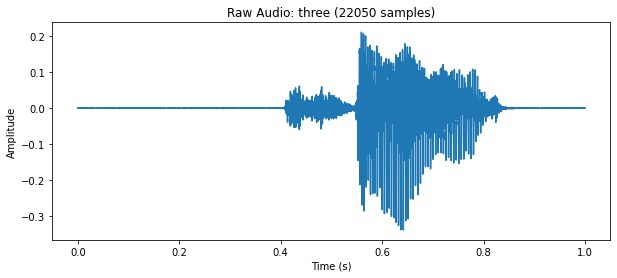

In [ ]:
timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(1, figsize=(10, 4))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax.plot(timesteps, clip)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Raw Audio: {} ({} samples)'.format(label, len(clip)))
plt.show()

##Fast Fourier Transform (FFT)
The FFT is an algorithm used to calculate the Fourier transform efficiently. 

Below we have run the FFT on the segmented signals from our `snippet` variable. 

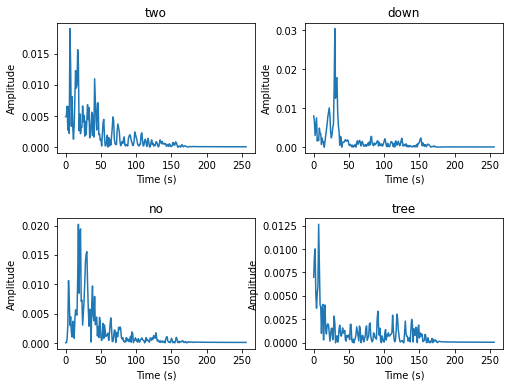

In [ ]:
def audio_wave_plot(snippet=snippet,n_fft=512, hop_length=1024):
  fig, axes = plt.subplots(2,2, figsize=(8, 6))
  fig.subplots_adjust(hspace=0.5,wspace=0.25)
  for idx, axs in enumerate(axes):
    for ax, snip in zip(axs, snippet[2*idx: 2 + 2*idx]):
      label = re.findall(pat, snip)[-1]
      clip, sample_rate = librosa.load(snip)
      timesteps = np.arange(len(clip)) / sample_rate  # in seconds
      ft = np.abs(librosa.stft(clip[:n_fft], hop_length = n_fft+1, n_fft = n_fft))
      ax.plot(ft)
      ax.set_xlabel('Time (s)')
      ax.set_ylabel('Amplitude')
      ax.set_title('{}'.format(label))
  plt.show()
audio_wave_plot()

##Spectogram
A spectrogram is a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies

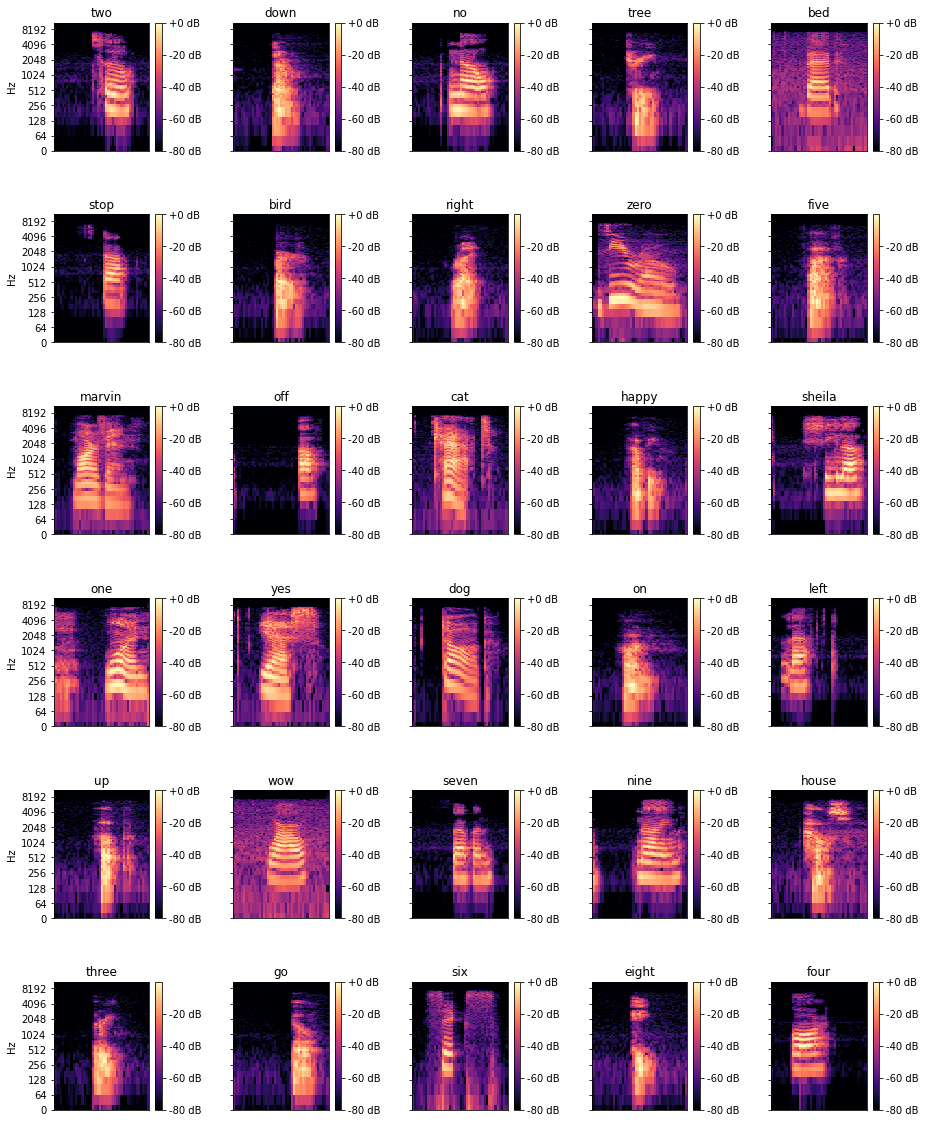

In [ ]:
def spectogram_plot(snippet=snippet, hop_length=512, n_fft=512):
  fig, axes = plt.subplots(6,5, figsize=(15, 20))
  fig.subplots_adjust(hspace=0.5,wspace=0.5)

  for idx, axs in enumerate(axes):
    for ax, snip in zip(axs, snippet[5*idx: 5 + 5*idx]):
      label = re.findall(pat, snip)[-1]
      clip, sample_rate = librosa.load(snip)
      
      spec = librosa.amplitude_to_db(np.abs(librosa.stft(clip, hop_length=hop_length, n_fft = n_fft)), ref=np.max)
      img = librosa.display.specshow(spec, y_axis='log', sr=sample_rate, hop_length=hop_length, x_axis=None, ax=ax)
      
      ax.set(title=label)
      ax.label_outer()
      fig.colorbar(img, ax=ax, format="%+2.f dB")
  plt.show()
spectogram_plot()

##Mel-Spectograms
The Mel Scale is a unit of pitch such that equal distances in pitch sounded equally distant to the listener.

The frequencies are converted to this mel scale through mathematical operations.


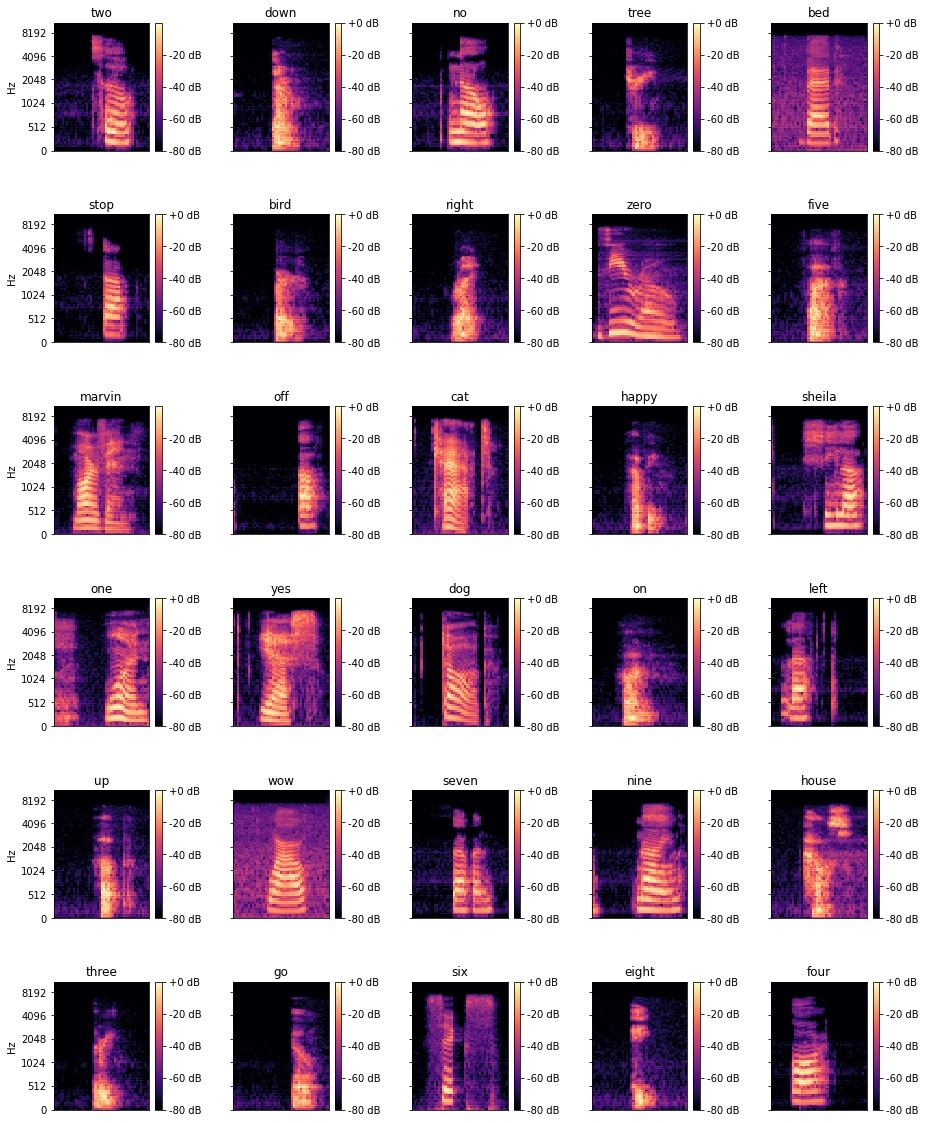

In [ ]:
def mel_spectogram_plot(snippet=snippet, hop_length=512, n_fft=512):
  fig, axes = plt.subplots(6,5, figsize=(15, 20))
  fig.subplots_adjust(hspace=0.5,wspace=0.5)

  for idx, axs in enumerate(axes):
    for ax, snip in zip(axs, snippet[5*idx: 5 + 5*idx]):
      label = re.findall(pat, snip)[-1]
      clip, sample_rate = librosa.load(snip)
      
      fmax = sample_rate/2

      spect = librosa.feature.melspectrogram(clip,sr= sample_rate, n_fft = n_fft, hop_length = hop_length)
      img = librosa.display.specshow(librosa.power_to_db(spect, ref=np.max),
                               y_axis='mel', x_axis=None,fmax = fmax, ax=ax)

      ax.set(title=label)
      ax.label_outer()
      fig.colorbar(img,ax=ax,format='%+2.0f dB')
  plt.show()
mel_spectogram_plot()

Mel-spectogram works best with large amounts of data and strong classifier like Convolutional Neural Networks.

##MFCC Spectogram
MFCC Spectrogram can be computed through two steps:

1. Take logs of Mel spectrogram.
2. Compute DCT on logs.

MFCC is a very compressible representation, often using just 20 or 13 coefficients instead of 32-64 bands in Mel spectrogram


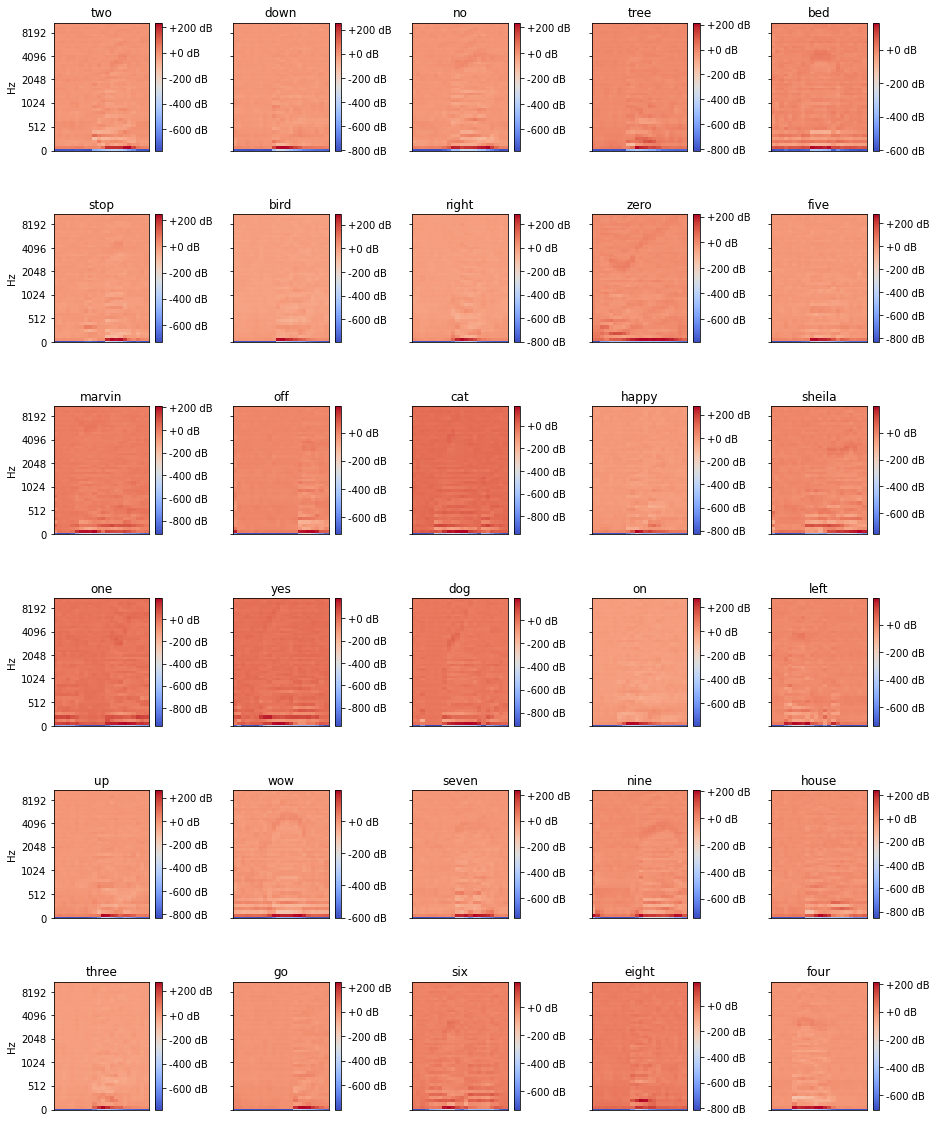

In [ ]:
def mfcc_spectogram_plot(snippet=snippet, hop_length=512, n_fft=512):
  fig, axes = plt.subplots(6,5, figsize=(15, 20))
  fig.subplots_adjust(hspace=0.5,wspace=0.5)

  for idx, axs in enumerate(axes):
    for ax, snip in zip(axs, snippet[5*idx: 5 + 5*idx]):
      label = re.findall(pat, snip)[-1]
      clip, sample_rate = librosa.load(snip)
      fmax = sample_rate/2

      mfccs = librosa.feature.mfcc(clip,sr= sample_rate, n_fft = n_fft, n_mfcc = 50, hop_length = hop_length, dct_type = 1)
      img = librosa.display.specshow(mfccs,y_axis='mel', x_axis=None,fmax = fmax, ax=ax)
      
      ax.set(title=label)
      ax.label_outer()
      fig.colorbar(img,ax=ax,format='%+2.0f dB')
  plt.show()
mfcc_spectogram_plot()

#Save Images

Create a directory to save all the spectogram, mel-spectogram and MFCC images!

In [ ]:
def create_dir(seg):
  os.makedirs(seg, exist_ok = True)
  train_images = os.path.join(PATH, seg)
  for cat in cats:
    os.makedirs(os.path.join(seg, cat), exist_ok=True)

def dir():
  labels = ['spec','mel_spec','mfcc']
  for lab in labels: 
    os.makedirs(lab,exist_ok=True)
    train_img = os.path.join(PATH,os.path.join(lab,'train_images')) 
    create_dir(train_img)
    
dir()

##Save Spectogram Images for Training

In [ ]:
def spectogram_train(examples):
  hop_length = 512
  n_fft = 512

  spec_images = '/content/spec/train_images'

  for idx,ex in enumerate(examples): 
    if idx%1000 == 0: print(idx)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    
    label, name = re.findall(pat,ex)[-1], re.findall(r'[\w]+.wav',ex)[0]
    clip, sample_rate = librosa.load(ex)
    
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(clip, hop_length=hop_length, n_fft = n_fft)), ref=np.max)
    p = librosa.display.specshow(spec, y_axis=None, sr=sample_rate, ax = ax,hop_length=hop_length, x_axis=None)
    fig.savefig(f'{spec_images}/{label}/{name[:-3]}jpg')

spectogram_train(examples)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000


In [ ]:
!zip -r /content/spectogram.zip /content/spec

##Save Mel-Spectogram Images

In [ ]:
def mel_spectogram_train(examples):
  hop_length = 512
  n_fft = 512

  mfcc_images = '/content/mfcc/train_images'

  for idx,ex in enumerate(examples): 
    if idx%1000 == 0: print(idx)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    
    label, name = re.findall(pat,ex)[-1], re.findall(r'[\w]+.wav',ex)[0]
    clip, sample_rate = librosa.load(ex)

    fmax = sample_rate/2

    spect = librosa.feature.melspectrogram(clip,sr= sample_rate, n_fft = n_fft, hop_length = hop_length)
    img = librosa.display.specshow(librosa.power_to_db(spect, ref=np.max), y_axis=None, x_axis=None,fmax = fmax, ax=ax)

    fig.savefig(f'{mfcc_images}/{label}/{name[:-3]}jpg')

mel_spectogram_train(snippet)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000


In [ ]:
# !zip -r mel_spectogram.zip /content/mel_spec

##Save MFCC Spectogram Images

In [ ]:
def mfcc_spectogram_train(examples):
  hop_length = 512
  n_fft = 512

  mfcc_images = '/content/mfcc/train_images'

  for idx,ex in enumerate(examples): 
    if idx%1000 == 0: print(idx)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)

    label, name = re.findall(pat,ex)[-1], re.findall(r'[\w]+.wav',ex)[0]
    clip, sample_rate = librosa.load(ex)

    fmax = sample_rate/2

    mfccs = librosa.feature.mfcc(clip,sr= sample_rate, n_fft = n_fft, n_mfcc = 50, hop_length = hop_length, dct_type = 1)
    img = librosa.display.specshow(mfccs,y_axis=None, x_axis=None,fmax = fmax, ax=ax)

    fig.savefig(f'{mfcc_images}/{label}/{name[:-3]}jpg')

mfcc_spectogram_train(examples)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000


In [ ]:
!zip -r mfcc.zip /content/mfcc

Streaming output truncated to the last 5000 lines.
  adding: content/mfcc/train_images/nine/eb3f7d82_nohash_0.jpg (deflated 9%)
  adding: content/mfcc/train_images/nine/0a7c2a8d_nohash_1.jpg (deflated 7%)
  adding: content/mfcc/train_images/nine/9efe5140_nohash_1.jpg (deflated 7%)
  adding: content/mfcc/train_images/nine/214ccb20_nohash_0.jpg (deflated 6%)
  adding: content/mfcc/train_images/nine/3cdecb0b_nohash_0.jpg (deflated 7%)
  adding: content/mfcc/train_images/nine/229978fd_nohash_2.jpg (deflated 6%)
  adding: content/mfcc/train_images/nine/edd8bfe3_nohash_0.jpg (deflated 7%)
  adding: content/mfcc/train_images/nine/6f689791_nohash_0.jpg (deflated 7%)
  adding: content/mfcc/train_images/nine/90b0b91a_nohash_0.jpg (deflated 11%)
  adding: content/mfcc/train_images/nine/a60a09cf_nohash_0.jpg (deflated 7%)
  adding: content/mfcc/train_images/nine/7ab5b8f7_nohash_3.jpg (deflated 7%)
  adding: content/mfcc/train_images/nine/686d030b_nohash_2.jpg (deflated 9%)
  adding: content/mfcc/t